In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.vision import *
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [6]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/siddhant/.fastai/data/planet')

In [12]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
# ! cp train-jpg.tar.7z /home/siddhant/.fastai/data/planet/
# ! 7z e /home/siddhant/.fastai/data/planet/train-jpg.tar.7z
# ! tar -xvf train-jpg.tar

In [7]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
# flip a few images vertically, but warp should be zero since this is top view from a satellite
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [9]:
# pick up the data from path/train-jpg, splitting 20% off as validation set
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [10]:
# getting the train and valid data loaders into a databunch
# initially using size 128, applying tfms
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

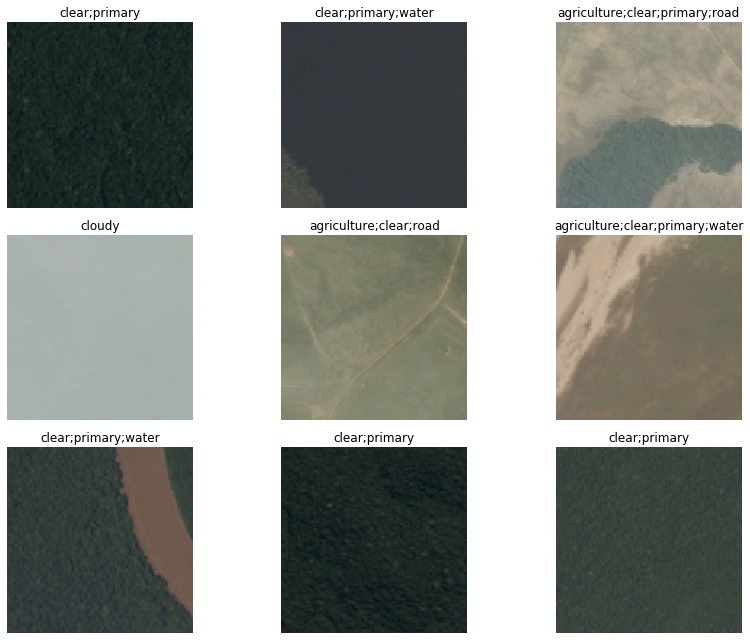

In [17]:
data.show_batch(rows=3, figsize=(12,9))

In [11]:
arch = models.resnet50
# kaggle is using fbeta 2
# partial function to pick all the predictions above thresh, EACH time acc_02 is used
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


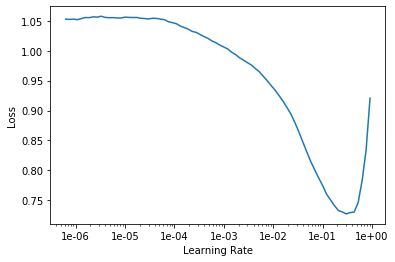

In [21]:
learn.recorder.plot()

In [12]:
# picking 1e-2, since we're just entering the slope there
# well before the valley
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138827,0.114746,0.943487,0.901009,03:35
1,0.112625,0.101368,0.952375,0.909330,03:17
2,0.103316,0.093308,0.951139,0.920121,03:18
3,0.093249,0.087841,0.954365,0.922667,03:17
4,0.091767,0.086768,0.955724,0.924424,03:18


In [14]:
learn.save('stage-1-rn50')
# now training the initial layers as well
learn.unfreeze()
learn.lr_find()

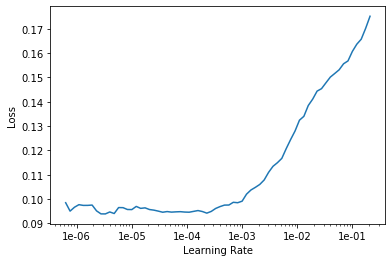

In [24]:
learn.recorder.plot()

In [15]:
# 1e-5 for the first layers - well before the increase in losses
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098198,0.091825,0.954220,0.921825,04:23
1,0.096421,0.090701,0.951749,0.920218,04:23
2,0.091261,0.085128,0.956538,0.925706,04:24
3,0.085483,0.083217,0.957715,0.927678,04:23
4,0.080725,0.082446,0.958129,0.929528,04:24


In [16]:
learn.save('stage-2-rn50')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)
# interp.plot_top_losses(9, figsize=(12,9))

False

In [21]:
# use the full image size now, transfer the learning from stage-1
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


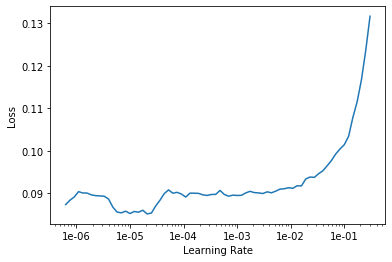

In [22]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085133,0.084601,0.955339,0.927153,09:16
1,0.083167,0.082736,0.959510,0.929021,09:14
2,0.083573,0.082488,0.957454,0.928574,09:13
3,0.083034,0.082001,0.958195,0.929037,09:13
4,0.081174,0.082150,0.958028,0.929032,09:13


In [24]:
learn.save('stage-3-rn50')

In [25]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


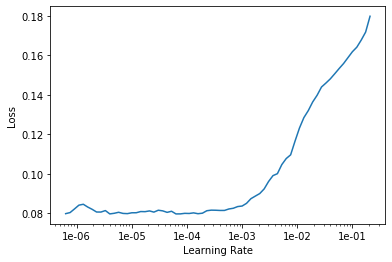

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, slice(1e-5, (1e-3)/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084219,0.082573,0.959314,0.929080,12:17
1,0.084040,0.083645,0.956974,0.928557,12:16
2,0.080898,0.081163,0.959234,0.930842,12:17
3,0.076862,0.081357,0.959074,0.930854,12:19
4,0.074466,0.080954,0.959793,0.931481,12:22


In [28]:
learn.save('stage-4-rn50')